In [50]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import glob

sns.set_theme()

In [59]:
def load_file(fn):
    data = {"simple": False, "filename": fn}
    with open(fn) as f:
        for line in f:
            if line.startswith("runtime_s:"):
                data["runtime_gen"] = float(line.split(":")[1])
                
            elif line.startswith("	Maximum resident set size"):
                data["max_rss"] = int(line.split(":")[1])
                
            elif line.startswith("	Elapsed (wall clock) time "):
                pass
            
            elif line.startswith("	Command being timed:"):
                args = line.split(":", maxsplit=1)[1].strip()[1:-1]
                argv = args.split(" ")
                
                i = 1
                while i < len(argv):
                    if "-a" == argv[i]:
                        data["algo"] = argv[i+1]
                    elif "-s" == argv[i]:
                        data["seed"] = int(argv[i+1])
                    elif "-n" == argv[i]:
                        data["nodes"] = int(argv[i+1])
                    elif "-d" == argv[i]:
                        data["degree"] = int(argv[i+1])
                    elif "-e" == argv[i]:
                        data["exponent"] = float(argv[i+1])
                    elif "-p" == argv[i]:
                        data["simple"] = True
                        i -= 1
                    else:
                        i -= 1
                        
                    i += 2

    if "algo" in data:
        data["algo2"] = data["algo"] + "-" + ("simple" if data["simple"] else "parallel-edges")
               
    return data

rows = [load_file(f) for f in glob.glob("logs/*/n*.log")]
data = pd.DataFrame(rows)
data["rel_runtime"] = data["runtime_gen"] / data["nodes"] / data["degree"] * 1e9
data

,simple,filename,runtime_gen,algo,seed,nodes,degree,exponent,max_rss,algo2,rel_runtime
0,True,logs/dyn/n2097152_d5_s1_e8-1235345.log,4.026671,dyn,1235345,2097152,5,0.8,102180,dyn-simple,384.013271
1,False,logs/dyn/n67108864_d5_s0_e0-1235345.log,152.940917,dyn,1235345,67108864,5,0.0,3149488,dyn-parallel-edges,455.799452
2,True,logs/dyn/n1048576_d2_s1_e12-1235345.log,0.422058,dyn,1235345,1048576,2,1.2,52792,dyn-simple,201.253130
3,True,logs/dyn/n33554432_d10_s1_e10-1235345.log,185.831826,dyn,1235345,33554432,10,1.0,1576664,dyn-simple,553.822000
4,True,logs/dyn/n65536_d3_s1_e8-1235345.log,0.037869,dyn,1235345,65536,3,0.8,6872,dyn-simple,192.611501
...,...,...,...,...,...,...,...,...,...,...,...
1368,False,logs/polypa/n262144_d5_s0_e10-1235345.log,0.087961,polypa,1235345,262144,5,1.0,14384,polypa-parallel-edges,67.108607
1369,True,logs/polypa/n524288_d10_s1_e0-1235345.log,0.240687,polypa,1235345,524288,10,0.0,23404,polypa-simple,45.907379
1370,True,logs/polypa/n65536_d5_s1_e0-1235345.log,0.018050,polypa,1235345,65536,5,0.0,5456,polypa-simple,55.083823
1371,False,logs/polypa/n524288_d5_s0_e12-1235345.log,0.279592,polypa,1235345,524288,5,1.2,26604,polypa-parallel-edges,106.655713


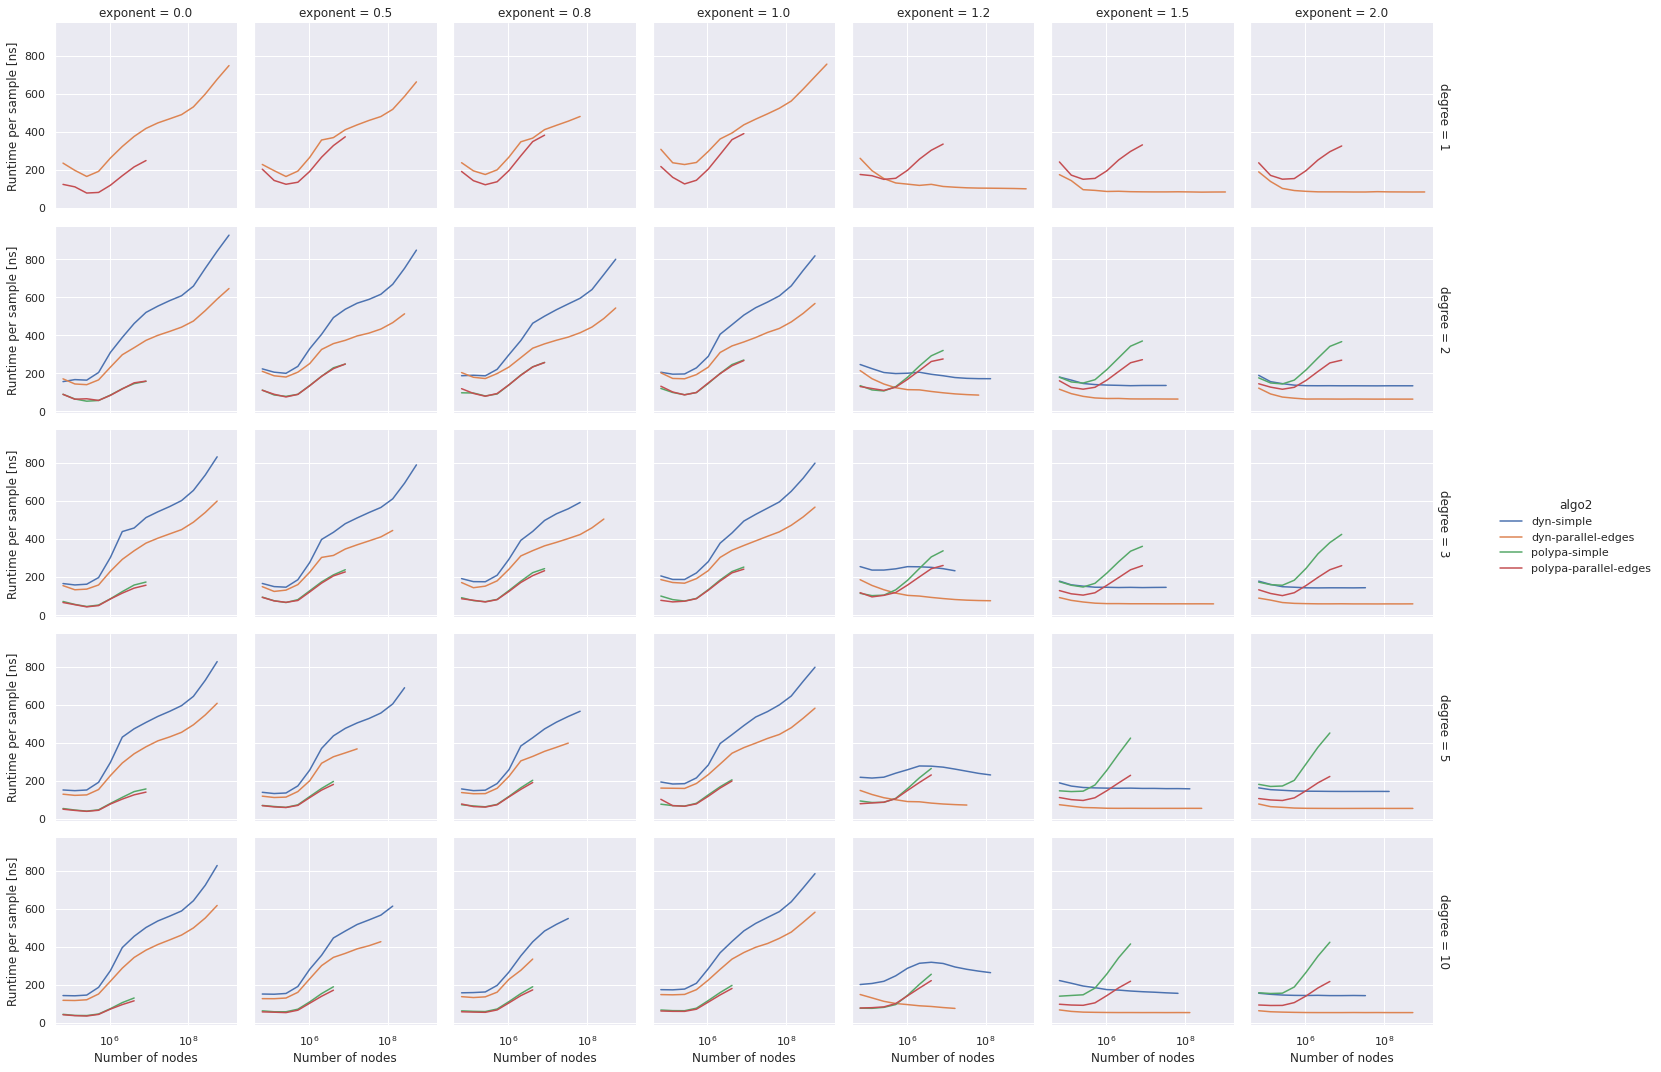

In [62]:
g = sns.FacetGrid(data, row="degree", col="exponent",  hue="algo2", margin_titles=True)
g.map(sns.lineplot, "nodes", "rel_runtime")
g.set_ylabels("Runtime per sample [ns]")
g.set_xlabels("Number of nodes")
plt.semilogx()
g.add_legend()
plt.savefig("seq-bench.png")

<Figure size 432x288 with 0 Axes>